In [1]:
from model.hero2vec import *
from utils.evaluation import *
from utils.dataset import DataFrameIterator

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset

In [4]:
def train(model, dataloader, loss_function=nn.CrossEntropyLoss(),
          init_lr=0.1, epochs=100, lr_decay_epoch = 30,
          print_epoch = 10, gpu=False):

    # Cuda is not critical for this task with low dimensionol inputs
    if gpu and torch.cuda.is_available():
        model.cuda()

    losses = []
    for epoch in range(epochs):

        # learning rate decay
        div, mod = divmod(epoch, lr_decay_epoch)
        if mod == 0:
            optimizer = optim.SGD(model.parameters(), lr=init_lr*(0.1)**div)

        total_loss = torch.Tensor([0])

        # iterate the dataset to load context heroes(team) and center hero(target)
        for teams, targets in dataloader:

            if gpu and torch.cuda.is_available():
                teams = teams.cuda()
                targets = targets.cuda()

            # wrap the embeddings of the team and target center hero to Variable
            inputs = autograd.Variable(teams)
            targets = autograd.Variable(targets.view(-1))

            # zero out the accumulated gradients
            model.zero_grad()

            # Run the forward pass
            out = model(inputs)

            # Compute your loss function.
            loss = loss_function(out, targets)

            # backpropagate and update the embeddings
            loss.backward()
            optimizer.step()

            # record total loss in this epoch
            total_loss += loss.cpu().data

        if epoch % print_epoch == 0:
            print('epoch: %d, loss: %.3f' % (epoch, total_loss/len(dataloader)))

        losses.append(total_loss/len(dataloader))
    # return losses for plot
    return np.array(losses)

In [5]:
def save_embeddings(model, filename = 'embeddings.npy'):
    embeddings = model.embeddings.weight.cpu().data.numpy()
    np.save(file = filename, arr=embeddings)

def plot_loss(losses):
    plt.figure(figsize=(8, 6), dpi=100)
    ax = plt.subplot(111)
    ax.plot(losses)
    ax.set_xlabel('Epochs', fontsize=24)
    ax.set_ylabel('Train_loss', fontsize=24)
    plt.show()

In [6]:
def main():
    # import DataFrame and hero2ix dictionary
    heroes_df = pd.read_csv('./input/teams.csv', index_col=0)
    hero2ix_df = pd.read_csv('./input/hero2ix.csv', index_col=0)
    heroes_df = heroes_df.dropna().reset_index(drop=True)
    hero2ix = dict(zip(hero2ix_df.hero, hero2ix_df.ID))
    heroes = hero2ix_df['hero'].values

    # train test split
    split = int(len(heroes_df)*0.9)
    heroes_train = heroes_df.iloc[:split]
    heroes_test = heroes_df.iloc[split:]

    # build dataset generator
    train_gen = DataFrameIterator(heroes_train, hero2ix)
    test_gen = DataFrameIterator(heroes_test, hero2ix)

    # Use Dataloader class in pytorch to generate batched data
    batch_size = 64
    loader_train = DataLoader(train_gen, batch_size=batch_size,
                              sampler=sampler.RandomSampler(train_gen),
                              num_workers=4)
    loader_test = DataLoader(test_gen, batch_size=batch_size,
                              sampler=sampler.SequentialSampler(test_gen),
                              num_workers=4)

    # define model, totally three models in hetor2vec.py
    model = CBOH(embedding_dim=10, heropool_size=len(hero2ix))

    # define loss function
    loss_function = nn.CrossEntropyLoss()

    # run train
    losses = train(model=model, dataloader=loader_train, loss_function=loss_function,
                   init_lr=0.2, epochs=30, lr_decay_epoch=10, print_epoch=5, gpu=True)

    # check test accuracy
    print('accuracy: ', accuracy(model, dataloader=loader_test,
                                 batch_size=batch_size, hero2ix=hero2ix, gpu=True))

    # plot loss vs epoch
    plot_loss(losses)

    # project embeddings to 2d plane
    plot_embeddings(model, heroes)

    # save embeddings as numpy arrays
    filename = './output/hero_embeddings.npy'
    save_embeddings(model, filename)

epoch: 0, loss: 1.726
epoch: 5, loss: 1.387
epoch: 10, loss: 1.369
epoch: 15, loss: 1.366
epoch: 20, loss: 1.365
epoch: 25, loss: 1.364
accuracy:  0.5834986772486772


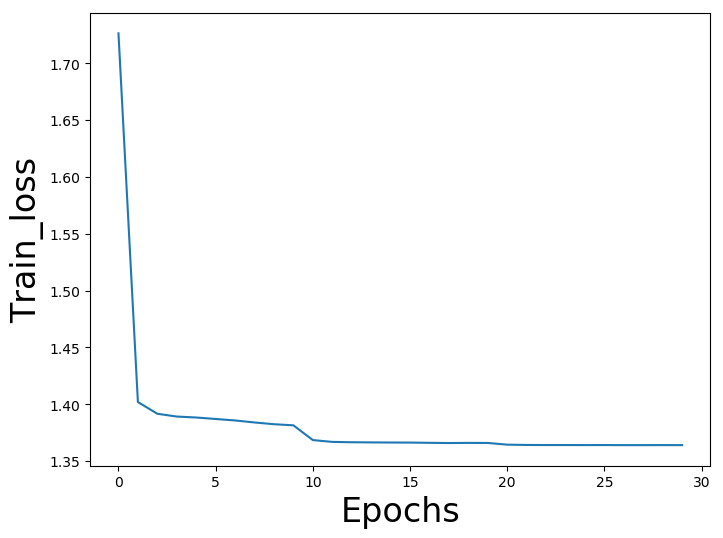

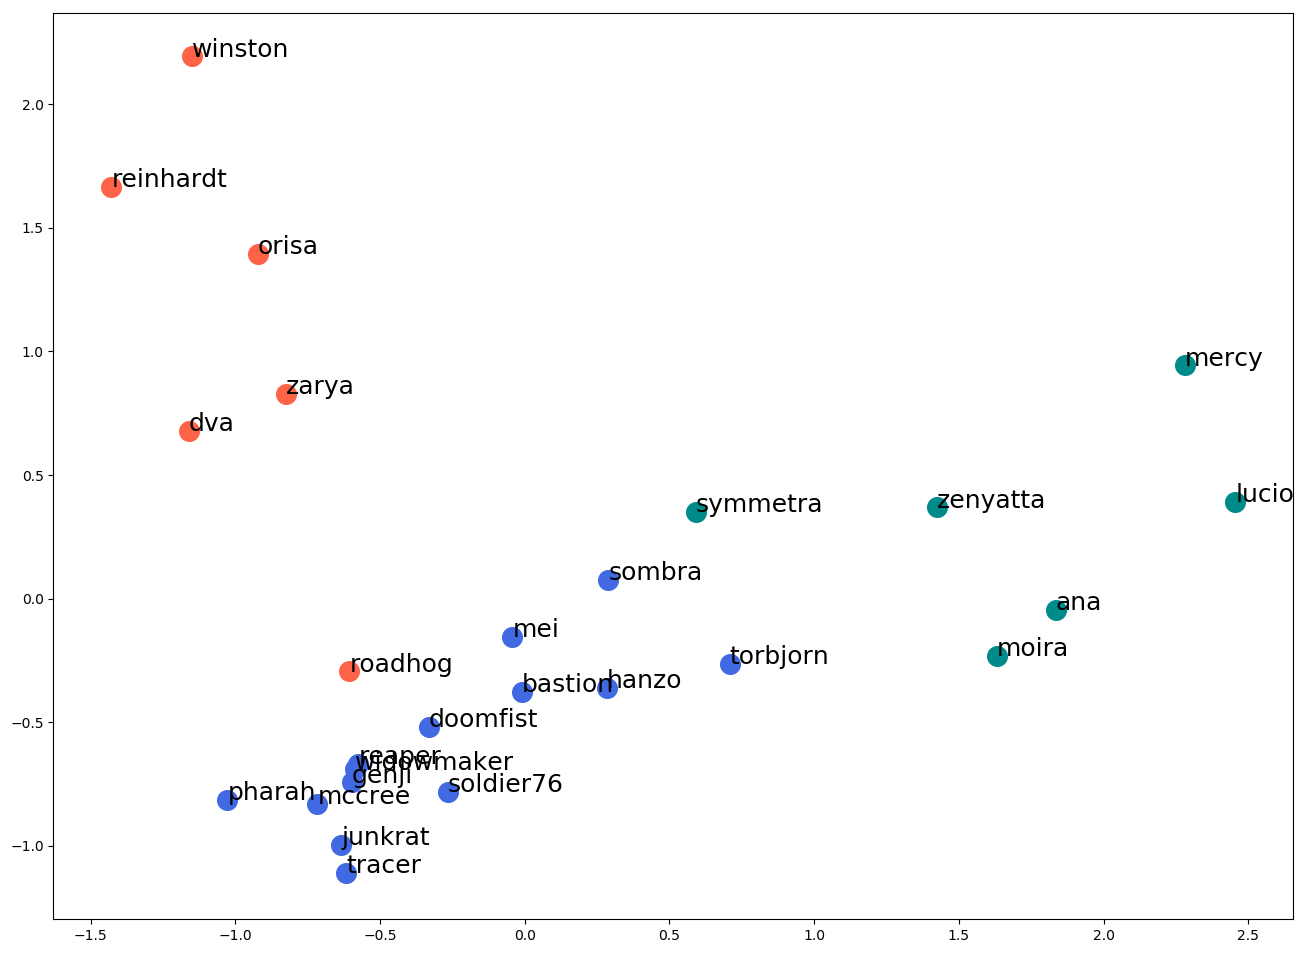

In [7]:
if __name__ == '__main__':
    main()